In [2]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
class Data(torch.utils.data.Dataset):
    def __init__(self, N):
        super(Data,self).__init__()
        self.inputs, self.labels = self.data_points(N)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,idx):
        x = torch.from_numpy(self.inputs[idx].reshape(-1)).float()
        y = torch.from_numpy(self.labels[idx].reshape(-1)).float()
        return x,y
    def data_points(self,n):
        radius = np.random.uniform(low = 0, high = 2, size = n).reshape(-1,1)
        angle = np.random.uniform(low = 0, high = 2*np.pi, size = n).reshape(-1,1)
        x1 = radius*np.cos(angle)
        x2 = radius*np.sin(angle)
        y = (radius<1).astype(int).reshape(-1)
        x = np.concatenate([x1,x2], axis = 1)
        print(x.shape,y.shape)
        return x,y

In [10]:
class MLP(torch.nn.Module):
    def __init__(self,arch = [2,16,1]):
        super(MLP,self).__init__()
        self.arch = arch
        self.H = torch.nn.Linear(self.arch[0], self.arch[1])
        self.O = torch.nn.Linear(self.arch[1], self.arch[2])
        self.A = torch.nn.Tanh()
        
    def forward(self,x):
        x = self.A(self.H(x))
        x = torch.sigmoid(self.O(x))
        return x

In [11]:
def Accuracy(y_pred, y_true):
    y_pred = (y_pred>0.5)
    return (y_pred.int() == y_true.int()).float().mean()

def Eval(model, dataloader):
    loss_function = torch.nn.BCELoss()
    x, y_true = next(dataloader.__iter__())
    
    if torch.cuda.is_available():
        x = x.cuda()
        y_true = y_true.cuda()
        
    y_pred = model(x)
    return loss_function(y_pred, y_true), Accuracy(y_pred, y_true)

In [12]:
def Train(model, dataloader_train, dataloader_val, dataloader_test, num_iter = 10000, epoches = 1, lr = 0.01):
    loss_function = torch.nn.BCELoss()
    history_train = []
    history_val = []
    history_test = []
    
    for i in range(0,epoches):
        for j in tqdm(range(0,num_iter)):
            
            x,y_true = next(dataloader_train.__iter__())
            
            if torch.cuda.is_available():
                x = x.cuda()
                y_true = y_true.cuda()
                
            y_pred = model(x)
            loss = loss_function(y_pred,y_true)
            model.zero_grad()
            loss.backward()
            
            for w in model.parameters():
                w.data.sub_(w.grad.data * lr)
                
            train_loss, train_acc = Eval(model, dataloader_train)
            val_loss, val_acc = Eval(model, dataloader_val)
            test_loss, test_acc = Eval(model, dataloader_test)

            history_train.append([train_loss.item(), train_acc.item()])
            history_val.append([val_loss.item(), val_acc.item()])
            history_test.append([test_loss.item(), test_acc.item()])
            
    return history_train, history_val, history_test

            
            

In [13]:
batch_size = 1024
dataset_train = Data(10000)
dataset_val = Data(2000)
dataset_test = Data(2000)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size = batch_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size)


(10000, 2) (10000,)
(2000, 2) (2000,)
(2000, 2) (2000,)


In [87]:
model = MLP()
num_iter=10
if torch.cuda.is_available():
    model.cuda()

history_train, history_val, history_test = Train(model, dataloader_train, dataloader_val, dataloader_test, num_iter=num_iter)


100%|██████████| 10/10 [00:00<00:00, 18.52it/s]


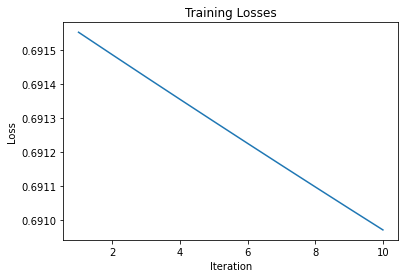

In [88]:
plt.figure()
plt.title("Training Losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(range(1, num_iter + 1),[a[0] for a in history_train])

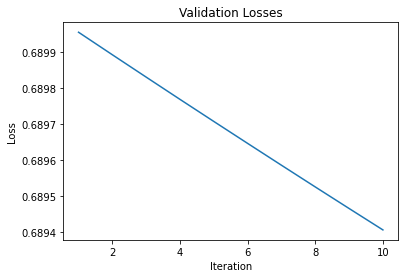

In [89]:
plt.figure()
plt.title("Validation Losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(range(1, num_iter + 1),[a[0] for a in history_val])

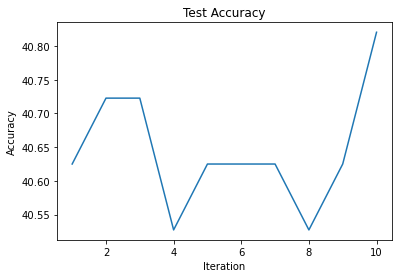

In [90]:
plt.figure()
plt.title("Test Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.plot(range(1, num_iter + 1),[a[1]*100 for a in history_test])